## Advertising campaign

An **advertising campaign** is a series of advertisement messages launched on different media channels to advertise a product/service.
It is characterized by a set of **subcampaigns**, each with a potentially different pair (ad, targeting), and by a **cumulative daily budget**. 

We'll focus on _pay-per-click_ advertising where an advertiser pays only once a user has clicked on his ad. To get an ad impressed, the advertiser take part in an auction, specifying a bid and a daily budget for each subcampaing. The advertiser's goal is to partition the cumulative daily budget over the subcampaigns in order to maximize the number of ad impressed, hence the expected revenue obtained by the advertisign campaign. 

_Note:_ we'll implicitly assume that the _bid value_ is automatically computed by the advertising platform once the daily budget is fixed.

## Optimization Problem

### Assumptions

1. The performance of every subcampaign is independent of the performance of the other subcampaigns
2. The values of bid and daily budget are finite

### Formal Model

*  $\max_{x_{j,t}, y_{j,t}} \sum_{j=1}^N v_{j} n_{j}(x_{j,t}, y_{j,t})$
  
  such that: 
  * $ \sum_{j=1}^N y_{j,t} \leq \bar{y}_{t}$, $\forall t \in T$

  * $\underline{x}_{j,t} \leq x_{j,t} \leq \bar{x}_{j,t}, \forall {j \in N}, \forall t \in T$
  
  * $\underline{y}_{j,y} \leq y_{j,t} \leq \bar{y}_{j,t}, \forall j \in N, \forall t \in T$
  
  where

  * $N$ number of subcampaigns
  * $C = \left\{C_{1}, ..., C_{N}\right\}$ advertising campaign
  * $T$ time horizon 
  * $t \in T$ instant of time 
  * $x_{j,t}$ bid of subcampaign *$C_{j}$* at time *t*
  * $y_{j,t}$ daily budget of subcampaign *$C_{j}$* at time *t*
  * $v_{j}$ value per click (impression) of subcampaign *$C_{j}$*
  * $n_{j}(x_{j}, y_{j})$ number of clicks (impressions) of subcampaign   *$C_{j}$* given the values of bid $x_{j}$ and budget $y_{j}$
  * $\bar{y}_{j}$ cumulative daily budget constraint
  * $\left[\underline{x}_{j,t}, \bar{x}_{j,t}\right]$ box constraints for the bid of subcampaign *$C_{j}$* at time *t*
  * $\left[\underline{y}_{j,t}, \bar{y}_{j,t}\right]$ box constraints for the budget of subcampaign *$C_{j}$* at time *t*

### Our Scenario

* Our advertising campaign is composed of 3 subcampaign with a cumulative budget of 10M €. 
* We execute the experiment over a week that is composed of 56 instants of time (8 for each half-day). 
* In the beginning we'll use a unique value per click (i.e. $v_{j}$=1) in order to maximize the total number of clicks, while at the end of the notebook we'll combine the advertising scenario together with the pricing scenario. 
* The budget constraint on each subcampaing will vary from 0 to the cumulative daily budget, in 11 evenly spaced values ($y_{j,t}\in[0,10]$).

In [1]:
advertising_env_id = 0 # id of the campaign to use

max_budget = 10 # maximal amount of budget
n_arms = 11 # number of equispaced values in which the budget is subdivided, starting from 0

sample_factor = 8 # number of samples in an half-day
horizon= 14 * sample_factor

import numpy as np
np.random.seed(1234)

In [2]:
from experiment_2 import *
exp2 = Experiment_2(max_budget, n_arms, advertising_env_id)

### Algorithm: Knapsack

In each instant of time $t \in T$:
1. The algorithm receives in input a table of values $v_{j} n_{j}(x_{j,t}, y_{j,t})$ for each value of bid $x_{j,t}$ and budget $y_{j,t}$
2. For each row, it selects the value of bid that maximize the cell's value
3. Once removed the dependency of the bid values, it constructs a second table where each row includes the expected revenue for different values of budget
4. A third table is constructed by considering a new subcampaing at a time. The value in each cell $(i,j)$ represent the maximum expected revenue obtained by splitting the budget $y_{j}$ between the subcampaing $C_{i}$ and the previous row.
5. The optimal revenue can be found by looking for the maximum value in the last row.
6. The optimal budget partition can be found by proceeding backward from the last row to the initial one.

Let's consider the clairvoyant solution, and let's see how the knapsack algorithm subdivide the cumulative daily budget (here 10) over the 3 subcampaigns, in order to found out the highest number of clicks.

In [3]:
exp2.run_clairvoyant()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,Budget
C0,0.000,110.621,151.316,166.287,171.795,173.821,174.566,174.840,174.941,174.978,174.992,4
C1,0.000,51.924,71.026,78.053,80.638,81.589,81.939,82.068,82.115,82.133,82.139,3
C2,0.000,45.151,61.762,67.872,70.120,70.947,71.252,71.363,71.405,71.420,71.425,3


By giving 4M € to the first campaign, and 3M € to the others, we'll reach the maximul number of $171.795+78.053+67.872 = 317,72$ K clicks.

## Combinatorial GP bandits
We put together combinatorial bandits with Gaussian Processes.

### Gaussian Processes
If we discrete the click-function curves and we estimate the values of each points, the number of samples required will be too large. By assuming that there is correlation among the points, we can use Gaussian Processes (GPs) to learn these functions. Given a set of samples in the 2D space (budget, clicks) and setting a kernel (usually Gaussian) a GP is able to provide a probability distribution over the results. This probabiliy distribution is crucial in order to assure the convergency of bandit algorithms. 


### Combinatorial GP Bandits
In a standard basic bandit problem we can pull a single arm over a set of arms and we observe the reward of the pulled arm. Instead, our arms are correlated and the reward of an arm provides information on the reward of the arms close to it.
A combinatorial GP bandits algorithm allows to pull any set of arms satisfying some combinatorial constraint.


### Our scenario
We model every subcampaign with a **Gaussian Process-Thompson Sampling (GP-TS)** as explained below. Our combinatorial constraint is represented by the **knapsack constraint** that force the cumulative daily budget to be no longer than a given value. Hence, we can at most an arm for each subcampaign such that the sum of them satisfy the knapsack constraints.

**Combinatorial GP-TS algorithm**

 At every time $t \in T$
 1. For every subcampaign *$j \in N$*, for every arm $a \in A$:
 
      $\tilde{n}_{a,j} \leftarrow Sample(\mathbb P(\mu_{a,j}=n_{a,j}))$
      
      
 2. Execute the Knapsack algorithm
 
      $\left\{\hat{y}_{j}\right\}_{j \in N} \leftarrow Knapsack(\left\{(v_{j} \tilde{n}_{a,j}(y), \bar{y}_{j}\right\}_{j \in N})$
 
 
 3. For every subcampaign *$j \in N$*, play arm $\hat{y}_{j}$
 
 
 4. Update the GP according to the observed rewards so far

Let's run an experiment and see how the Guassian Processes perform on each subcampaign.

Performing experiment:  1


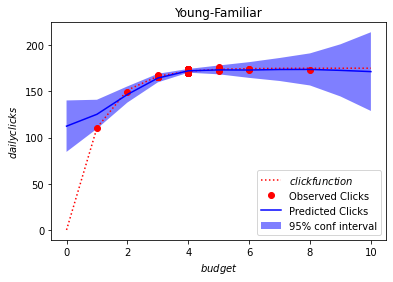

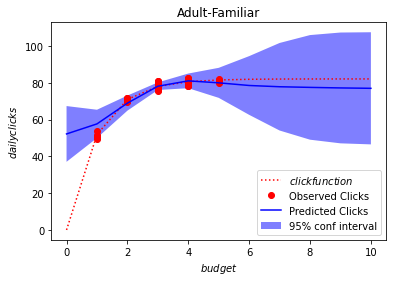

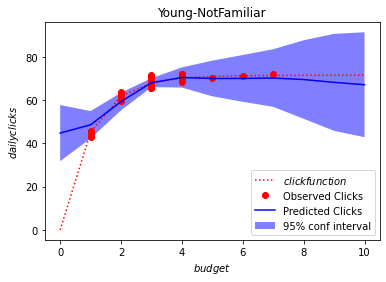

In [4]:
exp2.run(1, horizon, GP_graphs=True)

## Results

To obtain a more precise result we perform multiple experiments and we average the estimated click values.
After that we plot the average values of regrets and rewards.

In [5]:
n_experiments= 10 # number of experiment to perform

exp2.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


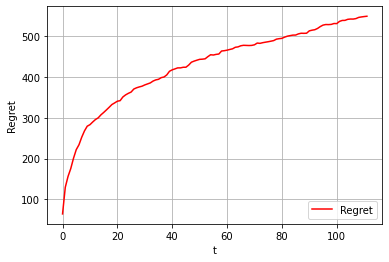

Clairvoyant value: 317.72032055226384


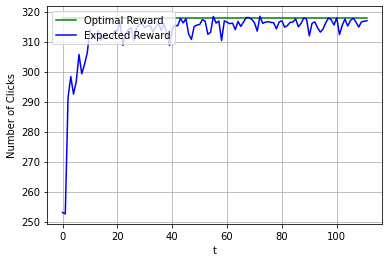

In [8]:
exp2.plot_regret()
print('Clairvoyant value: {}'.format(exp2.opt_super_arm_reward)) #clairvoyant value
exp2.plot_experiment()

## Non-Stationary Experiment

A non-stationary environment has the same configuration of the stationary one but the probability distribution of every arm can change over the time. Time is divided in phases and the reward functions are constant in each phase.

Our environment is divided by three phases (morning, evening and weekend) that compose the eleven _abrupt changes_ spread over the week. 

Standard bandit algorithms fail in non-stationary environments mainly because their bounds monotonically reduce. As a solution, we can use a sliding window to forget old samples. The regret lower bound is larger than in stationary environments since we are using less samples, but the comparison holds only on a the same stationary environment.

Non-stationary environments require permanent exploration otherwise the algorithm will suffer from a constant regret in the worst case. However this permanent exploration makes the regret to be much higher than the stationary case.

### Our Scenario
We use the **GP-Sliding Window-Thomposon Sampling** algorithm in each learner.
We ran a non-stationary experiment with the same configuration to easily compare the results with the stationary experiment.


**Combinatorial GP-SW-TS algorithm**

 At every time $t \in T$
 1. For every subcampaign *$j \in N$*, for every arm $a \in A$:
 
      $\tilde{n}_{a,j} \leftarrow Sample(\mathbb P(\mu_{a,j}=n_{a,j}))$
      
      
 2. Execute the Knapsack algorithm
 
      $\left\{\hat{y}_{j}\right\}_{j \in N} \leftarrow Knapsack(\left\{(v_{j} \tilde{n}_{a,j}(y), \bar{y}_{j}\right\}_{j \in N})$
 
 
 3. For every subcampaign *$j \in N$*, play arm $\hat{y}_{j}$
 
 
 4. Update the GP according to the **last observed rewards** (according to the sliding window size)

### Sliding window size setting

Let's execute three experiments with multiple learners having different sliding windows.

In [2]:
from experiment_3 import *
exp3 = Experiment_3(max_budget, n_arms, sample_factor, advertising_env_id, estimate_hyperparam=False)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3


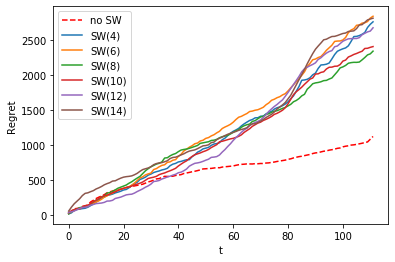

In [3]:
exp3.multiple_run(3, horizon=horizon, window_size=[4,6,8,10,12,14])
exp3.plot_multiple_regret()

We can observe that the a good sliding window size is 8, so let's set this dimension and re-run the experiment 10 times to achieve more precise results.

In [ ]:
#values = [horizon**0.3, horizon**0.4, 8,12,horizon**0.6,horizon**0.7]
#for v in range(len(values)):
#    print('sliding window size: {}'.format(int(values[v])))
#    exp3.run(3, horizon=horizon, window_size=int(values[v]))
#    exp3.plot_regret()

In [4]:
sliding_window = 8
n_experiments = 10
exp3.run(n_experiments, horizon, sliding_window)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


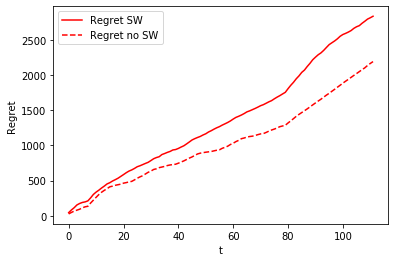

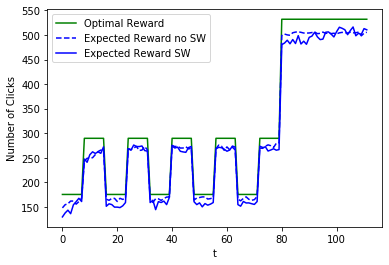

In [5]:
exp3.plot_regret()
exp3.plot_experiment()

Trying estimating kernel hyperparameters

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3


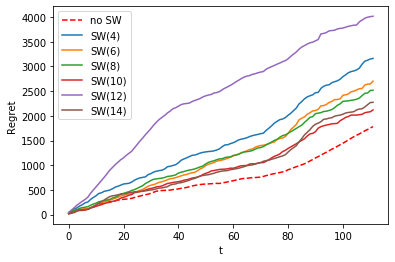

In [6]:
exp3 = Experiment_3(max_budget, n_arms, sample_factor, advertising_env_id, estimate_hyperparam=True)
exp3.multiple_run(3, horizon=horizon, window_size=[4,6,8,10,12,14])
exp3.plot_multiple_regret()

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


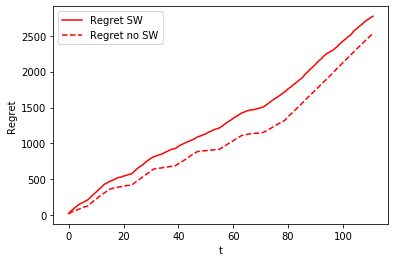

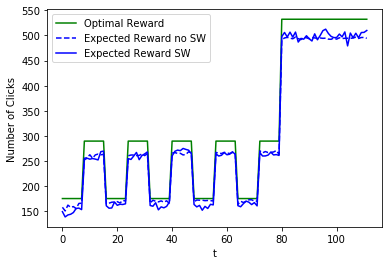

In [7]:
sliding_window = 10
n_experiments = 10
exp3.run(n_experiments, horizon, sliding_window)
exp3.plot_regret()
exp3.plot_experiment()